In [1]:
from tensorflow.keras import layers, models, optimizers, initializers, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.compat.v1 import disable_eager_execution
disable_eager_execution()
import tensorflow as tf
import numpy as np

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1 import ConfigProto, Session
import tensorflow.keras
config = ConfigProto(allow_soft_placement=True)

config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(Session(config=config))

In [2]:
from tensorflow.compat.v1 import enable_eager_execution

SyntaxError: invalid syntax (<ipython-input-2-29a9795140db>, line 1)

In [3]:
from tensorflow.keras.datasets import mnist
(train_data, train_label), (test_data, test_label) = mnist.load_data()

In [9]:
i = 8
from tensorflow.keras.preprocessing import image
image.save_img('/home/oneran/'+ str(i) + '.png', train_data[i].reshape(train_data[i].shape+(1,)))

In [3]:
from tensorflow.keras.utils import to_categorical
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)

In [4]:
train_data = train_data.reshape(train_data.shape+(1, ))
test_data = test_data.reshape(test_data.shape+(1, ))

In [7]:
model = models.Sequential()
#* with the input_shape (28, 28, 1)
#* Conv_block_1
model.add(
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1))
)
model.add(
    layers.Conv2D(16, (3, 3), activation='relu', padding='same')
)
model.add(
    layers.MaxPooling2D((2, 2))
)
#* Conv_block_2
model.add(
    layers.BatchNormalization()
)
model.add(
    layers.Conv2D(32, (3, 3), activation='relu', padding='same')
)
model.add(
    layers.Conv2D(32, (3, 3), activation='relu', padding='same')
)
model.add(
    layers.MaxPooling2D((2, 2))
)
#* Conv_block_3
model.add(
    layers.BatchNormalization()
)
model.add(
    layers.Conv2D(64, (3, 3), activation='relu', padding='same')
)
model.add(
    layers.Conv2D(64, (3, 3), activation='relu', padding='same')
)
model.add(
    layers.MaxPooling2D((2, 2))
)
#* Classifier
model.add(
    layers.Flatten()
)
model.add(
    layers.Dense(128, activation='relu')
)
model.add(
    layers.Dropout(0.5)
)
model.add(
    layers.Dense(128, activation='relu')
)
model.add(
    layers.Dense(10, activation='softmax', name='output')
)
model.compile(
    loss='categorical_crossentropy',
    metrics=['acc'],
    optimizer=optimizers.RMSprop(lr=1e-3)
)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)         

In [12]:
model.fit(
    train_data, train_label,
    epochs=10,
    batch_size=128
)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 207us/sample - loss: 0.2033 - acc: 0.9364
Epoch 2/10
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0626 - acc: 0.9829
Epoch 3/10
60000/60000 [==============================] - 13s 212us/sample - loss: 0.0482 - acc: 0.9867
Epoch 4/10
60000/60000 [==============================] - 12s 198us/sample - loss: 0.0385 - acc: 0.9900
Epoch 5/10
60000/60000 [==============================] - 13s 211us/sample - loss: 0.0346 - acc: 0.9908
Epoch 6/10
60000/60000 [==============================] - 12s 204us/sample - loss: 0.0312 - acc: 0.9919
Epoch 7/10
60000/60000 [==============================] - 14s 232us/sample - loss: 0.0297 - acc: 0.9924
Epoch 8/10
60000/60000 [==============================] - 12s 200us/sample - loss: 0.0259 - acc: 0.9936
Epoch 9/10
60000/60000 [==============================] - 12s 192us/sample - loss: 0.0249 - acc: 0.9940
Epoch 10/10
60000/60000 [================

In [13]:
models.save_model(model, '/home/oneran/mnist')

INFO:tensorflow:Assets written to: /home/oneran/mnist/assets


In [5]:
tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY

'serving_default'

In [10]:
model = tf.saved_model.load('/home/oneran/MyProject/mnist_ModelArts/model')

In [20]:
model.signatures['serving_default'](train_data)

TypeError: signature_wrapper(*, conv2d_6_input) missing required arguments: conv2d_6_input

In [6]:
from tensorflow.compat.v1.keras import backend as K
K.get_session().run(tf.compat.v1.global_variables_initializer())

# 定义预测接口的inputs和outputs
# inputs和outputs字典的key值会作为模型输入输出tensor的索引键
# 模型输入输出定义需要和推理自定义脚本相匹配
predict_signature = tf.compat.v1.saved_model.signature_def_utils.predict_signature_def(
    inputs={"images" : model.input},
    outputs={"scores" : model.output}
)

# 定义保存路径
builder = tf.compat.v1.saved_model.builder.SavedModelBuilder('/home/oneran/MyProject/mnist_ModelArts/model/model')

builder.add_meta_graph_and_variables(
    sess=K.get_session(),
    # 推理部署需要定义tf.saved_model.tag_constants.SERVING标签
    tags=[tf.compat.v1.saved_model.tag_constants.SERVING],
    # """
    # signature_def_map：items只能有一个，或者需要定义相应的key为
    # tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY
    # """
    signature_def_map={
        tf.compat.v1.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
            predict_signature
    }

)
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /home/oneran/MyProject/mnist_ModelArts/model/model/saved_model.pb


b'/home/oneran/MyProject/mnist_ModelArts/model/model/saved_model.pb'

In [44]:
img = np.random.random((28, 28, 1))

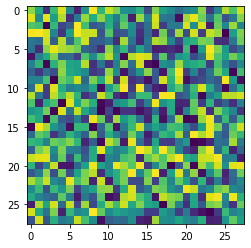

In [45]:
from matplotlib import pyplot as plt
plt.imshow(img)
from tensorflow.keras.preprocessing import image

In [46]:
img_temp = image.array_to_img(img)
image.save_img('/home/oneran/test.png', img)

In [50]:
image.save_img('/home/oneran/test.png', img)

In [49]:
img_temp